In [2]:
!pip install rasterio albumentations
!pip install torchvision segmentation-models-pytorch

In [16]:
# Standard libraries
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as TF

# Image I/O and processing
import cv2
import rasterio
import tifffile as tiff
import seaborn as sns
import pandas as pd

# Data augmentation and transforms
import albumentations as A
from albumentations import (
    HorizontalFlip, VerticalFlip, RandomBrightnessContrast, Rotate, Resize, Normalize, Compose,RandomRotate90, GaussNoise
)
from albumentations.pytorch import ToTensorV2
import torch.nn.functional as F

# Model and segmentation
import segmentation_models_pytorch as smp

# Utilities
from sklearn.model_selection import train_test_split
from tqdm import tqdm


11648
(512, 512, 3)


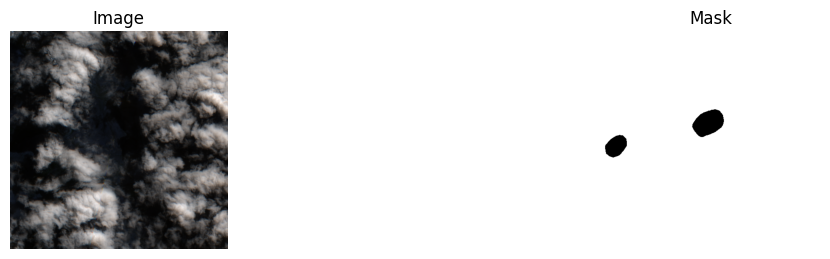

In [41]:
# Display image and mask pairs
plt.figure(figsize=(12, 12))

image_path = '/kaggle/input/cloud-masking-dataset/content/train/data/463625.tif'
mask_path = '/kaggle/input/cloud-masking-dataset/content/train/masks/463625.tif'

# Load image and mask
image = tiff.imread(image_path)  # shape: (H, W, 4)
mask = tiff.imread(mask_path)

# Extract RGB channels only
rgb_image = image[:, :, :3]
# Normalize image if values are outside [0, 1] or [0, 255]
if rgb_image.dtype != np.uint8:
    rgb_image = rgb_image.astype(np.float32)
    rgb_image = (rgb_image - rgb_image.min()) / (rgb_image.max() - rgb_image.min())

# Plot RGB image
plt.subplot(5, 2, 1)
plt.imshow(rgb_image)
plt.title(f'Image')
plt.axis('off')
# Plot corresponding mask
plt.subplot(5, 2, 2)
plt.imshow(mask, cmap='gray')
plt.title('Mask')
plt.axis('off')
# Extract RGB channels only
rgb_image = image[:, :, :3]
print(rgb_image.shape)
plt.tight_layout()
plt.show()

# Correlation test

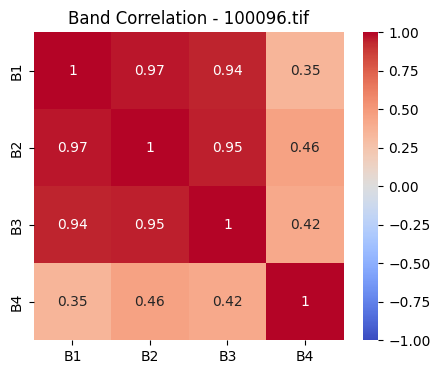

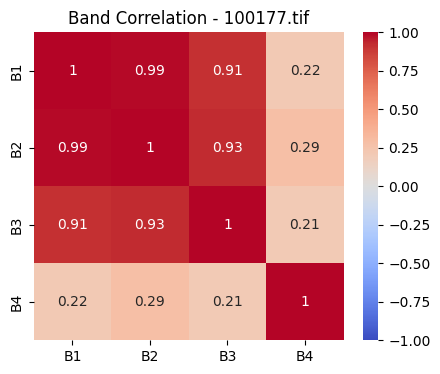

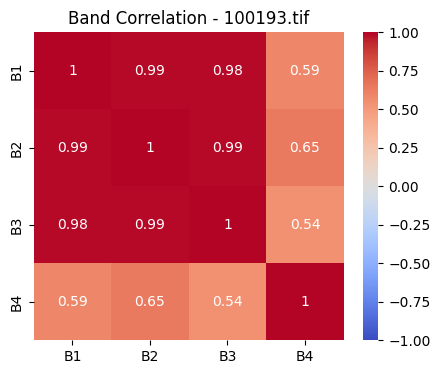

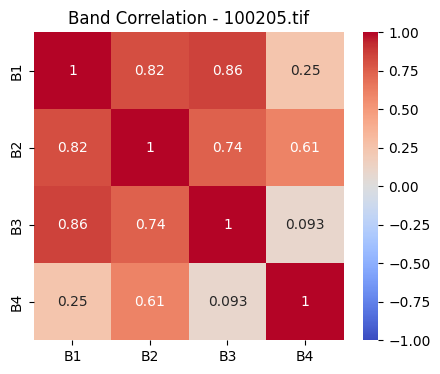

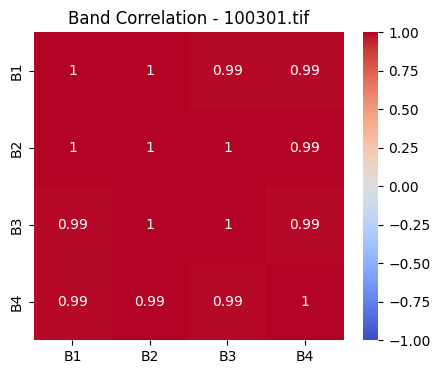

[          B1        B2        B3        B4
 B1  1.000000  0.965129  0.942701  0.348919
 B2  0.965129  1.000000  0.950262  0.457126
 B3  0.942701  0.950262  1.000000  0.418876
 B4  0.348919  0.457126  0.418876  1.000000,
           B1        B2        B3        B4
 B1  1.000000  0.986562  0.907420  0.216054
 B2  0.986562  1.000000  0.925737  0.287238
 B3  0.907420  0.925737  1.000000  0.206865
 B4  0.216054  0.287238  0.206865  1.000000,
           B1        B2        B3        B4
 B1  1.000000  0.991029  0.984401  0.586192
 B2  0.991029  1.000000  0.986578  0.646869
 B3  0.984401  0.986578  1.000000  0.542060
 B4  0.586192  0.646869  0.542060  1.000000,
           B1        B2        B3        B4
 B1  1.000000  0.818577  0.855463  0.245995
 B2  0.818577  1.000000  0.743263  0.607283
 B3  0.855463  0.743263  1.000000  0.092924
 B4  0.245995  0.607283  0.092924  1.000000,
           B1        B2        B3        B4
 B1  1.000000  0.996227  0.987758  0.991557
 B2  0.996227  1.000000  0.9

In [5]:
dataset_path = "/kaggle/input/cloud-masking-dataset/content/train"

data_dir = os.path.join(dataset_path, 'data')

# Get and sort image filenames
image_filenames = sorted([f for f in os.listdir(data_dir)])[:5]

def show_band_correlation(image_dir, image_files, num_samples=5):
    all_corrs = []

    for img_name in image_files[:num_samples]:
        img_path = os.path.join(image_dir, img_name)
        with rasterio.open(img_path) as src:
            image = src.read().astype(np.float32)  # shape: [4, H, W]

        # Reshape to [H*W, 4] for band-wise comparison
        h, w = image.shape[1], image.shape[2]
        pixels = image.reshape(4, -1).T  # shape: [H*W, 4]

        # Compute correlation matrix
        df = pd.DataFrame(pixels, columns=['B1', 'B2', 'B3', 'B4'])
        corr = df.corr()
        all_corrs.append(corr)

        # Plot correlation matrix
        plt.figure(figsize=(5, 4))
        sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
        plt.title(f'Band Correlation - {img_name}')
        plt.show()

    return all_corrs

show_band_correlation(data_dir,image_filenames)

# U-Net ++

In [30]:
def filter_image_files(image_dir, mask_dir, image_files):
    valid_files = []
    for file_name in tqdm(image_files):
        mask_path = os.path.join(mask_dir, file_name)
        try:
            with rasterio.open(mask_path) as src:
                mask = src.read(1)  # Read the first channel
                if not (np.all(mask == 0) or np.all(mask == 1)):
                    valid_files.append(file_name)
        except Exception as e:
            print(f"Failed to read mask {file_name}: {e}")
            continue
    return valid_files

In [31]:
# Paths to your merged dataset
image_dir = '/kaggle/input/cloud-masking-dataset/content/train/data'
mask_dir = '/kaggle/input/cloud-masking-dataset/content/train/masks'

# Get list of all files (images)
all_images = os.listdir(image_dir)
filtered_images = filter_image_files(image_dir, mask_dir, all_images)

100%|██████████| 10573/10573 [00:40<00:00, 263.54it/s]


## Augmentation

In [42]:
# Paths
augmented_image_dir = 'augmented/images'
augmented_mask_dir = 'augmented/masks'

os.makedirs(augmented_image_dir, exist_ok=True)
os.makedirs(augmented_mask_dir, exist_ok=True)

# Augmentation pipeline
augmentation = Compose([
    Resize(128, 128),
    HorizontalFlip(p=0.5),
    VerticalFlip(p=0.5),
    RandomRotate90(p=0.5),
    # GaussNoise(var_limit=(10.0, 50.0), p=0.3),
    # RandomBrightnessContrast(p=0.2),
    # Normalize(mean=(0, 0), std=(1, 1)),
])

# How many augmentations per image?
AUG_PER_IMAGE = 10

def offline_augment_and_save(image_dir, mask_dir, image_files):
    for file_name in tqdm(image_files):
        img_path = os.path.join(image_dir, file_name)
        mask_path = os.path.join(mask_dir, file_name)

        # Read 4-channel image
        with rasterio.open(img_path) as src:
            image = src.read().astype(np.float32)
            image = np.transpose(image, (1, 2, 0))  # [H, W, 4]
            image = image[:, :, [0, 3]]             # Keep only bands 1 and 4 → shape [H, W, 2]

        # Read mask
        with rasterio.open(mask_path) as src:
            mask = src.read(1).astype(np.uint8)  # [H, W]

        for i in range(AUG_PER_IMAGE):
            augmented = augmentation(image=image, mask=mask)
            aug_image = augmented['image']
            aug_mask = augmented['mask']

            # Convert back to [C, H, W] for saving with rasterio
            aug_image_np = np.transpose(aug_image, (2, 0, 1)).astype(np.float32)
            aug_mask_np = aug_mask.astype(np.uint8)

            # Save image
            image_aug_path = os.path.join(augmented_image_dir, f"{file_name.replace('.tif', '')}_aug{i}.tif")
            with rasterio.open(
                image_aug_path, 'w',
                driver='GTiff',
                height=aug_image_np.shape[1],
                width=aug_image_np.shape[2],
                count=2,
                dtype=aug_image_np.dtype
            ) as dst:
                dst.write(aug_image_np)

            # Save mask
            mask_aug_path = os.path.join(augmented_mask_dir, f"{file_name.replace('.tif', '')}_aug{i}.tif")
            with rasterio.open(
                mask_aug_path, 'w',
                driver='GTiff',
                height=aug_mask_np.shape[0],
                width=aug_mask_np.shape[1],
                count=1,
                dtype=aug_mask_np.dtype
            ) as dst:
                dst.write(aug_mask_np, 1)
  

In [43]:
filtered_images = sorted(filtered_images)
# Split dataset: 80% train, 10% validation, 10% test
train_images, temp_images = train_test_split(filtered_images, test_size=0.2, random_state=42)
val_images, test_images = train_test_split(temp_images, test_size=0.5, random_state=42)

offline_augment_and_save(
    image_dir=image_dir,
    mask_dir=mask_dir,
    image_files=train_images,
)

# 3. After saving, list all augmented images
augmented_images = sorted(os.listdir('augmented/images'))

100%|██████████| 5727/5727 [07:53<00:00, 12.09it/s]


In [44]:
import re 

train_set = set()

for path in augmented_images:
    filename = os.path.basename(path)  # e.g., 'some_image_name_aug3.tif'
    match = re.match(r"(.+)_aug\d+\.tif", filename)
    if match:
        original_name = match.group(1) + ".tif"
        train_set.add(original_name)
        
# Convert to sets
val_set = set(val_images)
test_set = set(test_images)

# Check intersections
train_val_intersection = train_set & val_set
train_test_intersection = train_set & test_set
val_test_intersection = val_set & test_set

# Report
if train_val_intersection:
    print(f"Overlap between train and val: {len(train_val_intersection)} samples")
else:
    print("✅ No overlap between train and val")

if train_test_intersection:
    print(f"Overlap between train and test: {len(train_test_intersection)} samples")
else:
    print("✅ No overlap between train and test")

if val_test_intersection:
    print(f"Overlap between val and test: {len(val_test_intersection)} samples")
else:
    print("✅ No overlap between val and test")

✅ No overlap between train and val
✅ No overlap between train and test
✅ No overlap between val and test


In [45]:
class CloudSegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, image_files, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_files = image_files  # This will hold the specific split (train, val, or test)
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.image_dir, img_name)
        mask_path = os.path.join(self.mask_dir, img_name)  # Assuming image and mask have the same name

        # Load 4-band image: [4, H, W] → [H, W, 4]
        with rasterio.open(img_path) as src:
            image = src.read().astype(np.float32)
            image = np.transpose(image, (1, 2, 0))  # [H, W, 4]

        # Check if the image has 4 channels
        if image.shape[2] == 4:
            # Select the first and fourth channels (index 0 and 3)
            image = image[..., [0, 3]]  # [H, W, 2]
            
        # Load mask: [1, H, W] → [H, W]
        with rasterio.open(mask_path) as src:
            mask = src.read(1).astype(np.uint8)

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        mask = torch.tensor(mask, dtype=torch.long)

        return image, mask

In [46]:
val_test_transform = A.Compose([
    A.Resize(128, 128),
    ToTensorV2()
])

# Create DataLoader for Train, Validation, Test
train_dataset = CloudSegmentationDataset(image_dir='augmented/images', mask_dir='augmented/masks', image_files=augmented_images)
val_dataset = CloudSegmentationDataset(image_dir=image_dir, mask_dir=mask_dir, image_files=val_images, transform=val_test_transform)
test_dataset = CloudSegmentationDataset(image_dir=image_dir, mask_dir=mask_dir, image_files=test_images, transform=val_test_transform)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

In [47]:
print(f"Train set size: {len(train_loader.dataset)}")
print(f"Validation set size: {len(val_loader.dataset)}")
print(f"Test set size: {len(test_loader.dataset)}")

Train set size: 57270
Validation set size: 716
Test set size: 716


In [48]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"using {device}")
model = smp.UnetPlusPlus(
    encoder_name='resnet34',
    encoder_weights=None,    # no pretrained weights for 4-channel input
    in_channels=2,           # 4-band images
    classes=1                # Binary segmentation
)

model.to(device)

using cuda


UnetPlusPlus(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(2, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=Tru

In [49]:
def show_prediction(model, image_path, mask_path, epoch):
    print(image_path)
    model.eval()

    with torch.no_grad():
        # Load image and mask
        image = tiff.imread(image_path)  # shape: (H, W, 4)
        mask = tiff.imread(mask_path)
        image = image[:, :, [0, 3]]

        # Normalize and convert to tensor
        input_tensor = torch.tensor(image / 255.0).permute(2, 0, 1).unsqueeze(0).float().to(device)  # [1, 4, H, W]

        pred = model(input_tensor)
        pred_mask = torch.sigmoid(pred).squeeze().cpu().numpy()
        pred_mask = (pred_mask > 0.5).astype(np.uint8)
        print("uniqueeeeeeee",np.unique(pred_mask))

        # Extract the first channel for grayscale display
        display_image = image[:, :, 0]  # shape: (H, W) for displaying

        # Normalize and prepare the image for grayscale display
        if display_image.dtype != np.uint8:
            display_image = (display_image - display_image.min()) / (display_image.max() - display_image.min()) * 255
            display_image = display_image.astype(np.uint8)

        # Plot grayscale image
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 3, 1)
        plt.imshow(display_image, cmap='gray')
        plt.title(f'Grayscale Image (Channel 1)')
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(mask, cmap='gray')
        plt.title(f'Ground Truth')
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(pred_mask, cmap='gray')
        plt.title(f'Prediction (Epoch {epoch})')
        plt.axis('off')

        plt.tight_layout()
        plt.show()


Epoch 1/10:   0%|          | 0/14318 [00:00<?, ?it/s]

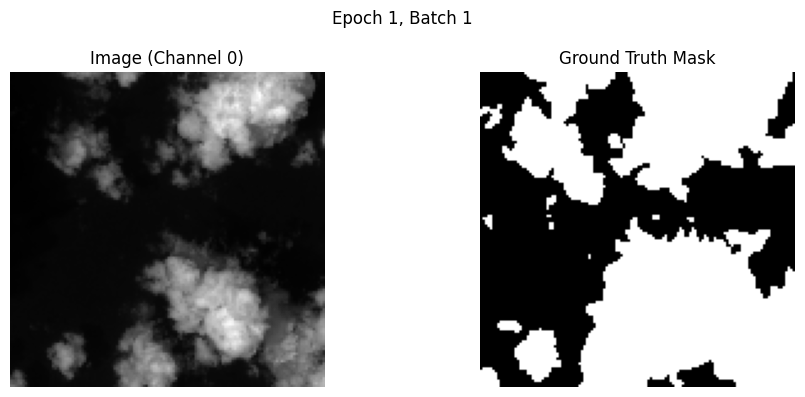

Epoch 1/10:   0%|          | 1/14318 [00:00<1:11:32,  3.34it/s]

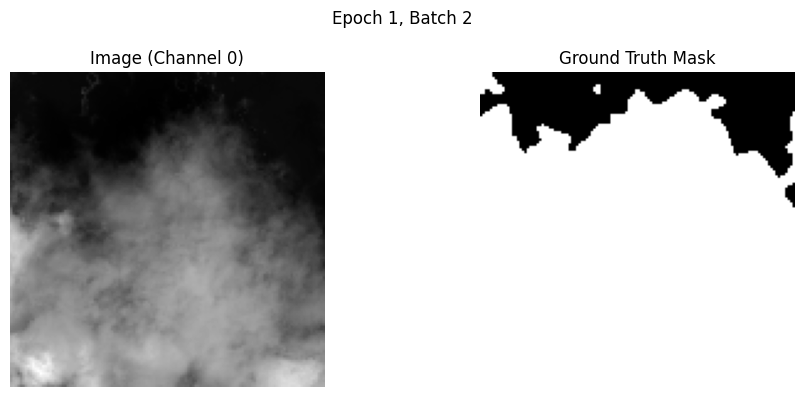

Epoch 1/10:   0%|          | 2/14318 [00:00<1:12:57,  3.27it/s]

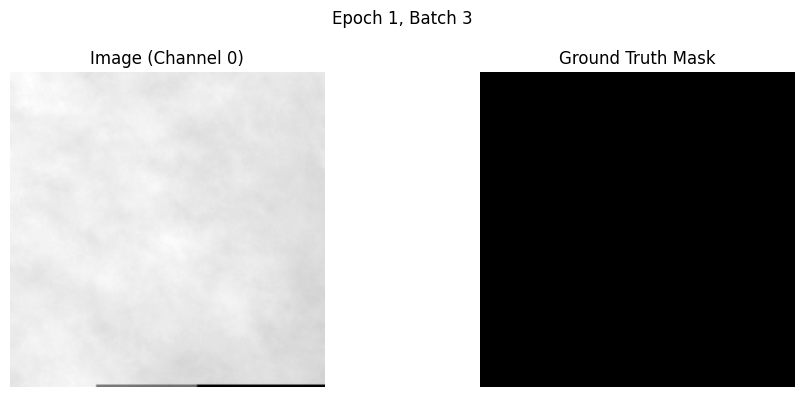

Epoch 1/10:   0%|          | 3/14318 [00:00<1:11:01,  3.36it/s]

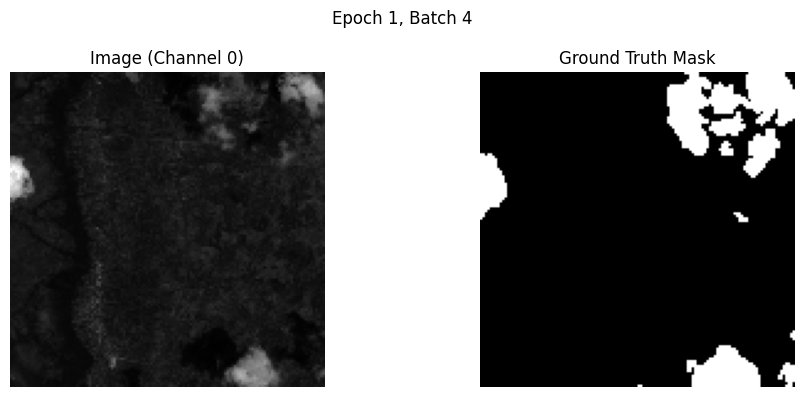

Epoch 1/10:   0%|          | 4/14318 [00:01<1:10:36,  3.38it/s]

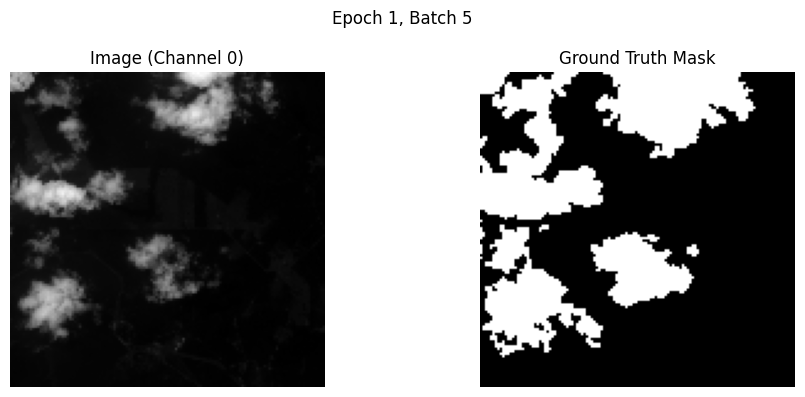

Epoch 1/10:   0%|          | 5/14318 [00:01<1:10:13,  3.40it/s]

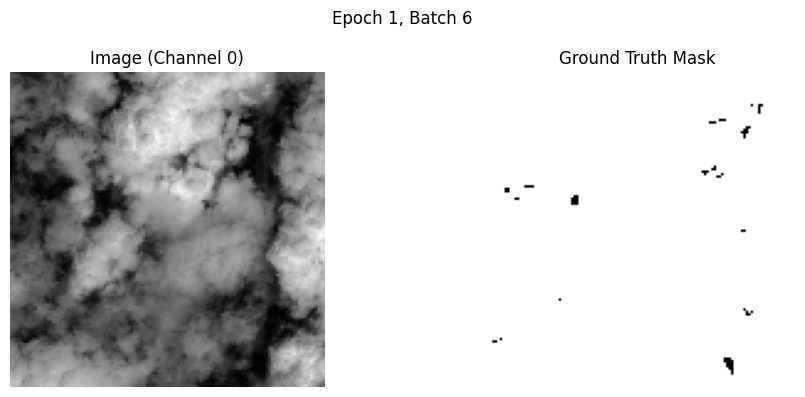

Epoch 1/10:   0%|          | 6/14318 [00:01<1:10:42,  3.37it/s]

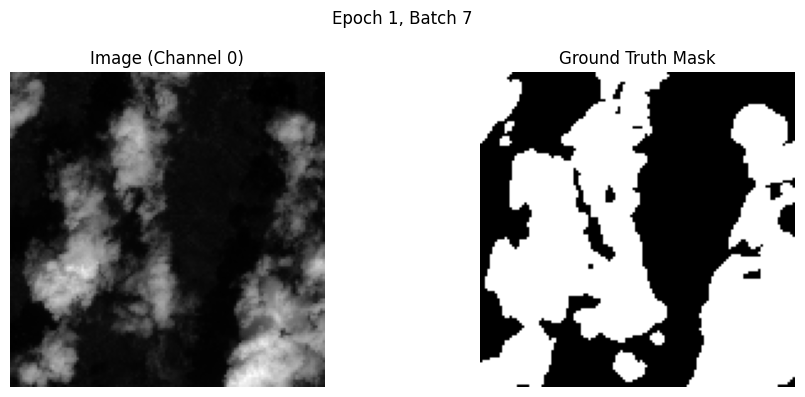

Epoch 1/10:   0%|          | 7/14318 [00:02<1:11:15,  3.35it/s]

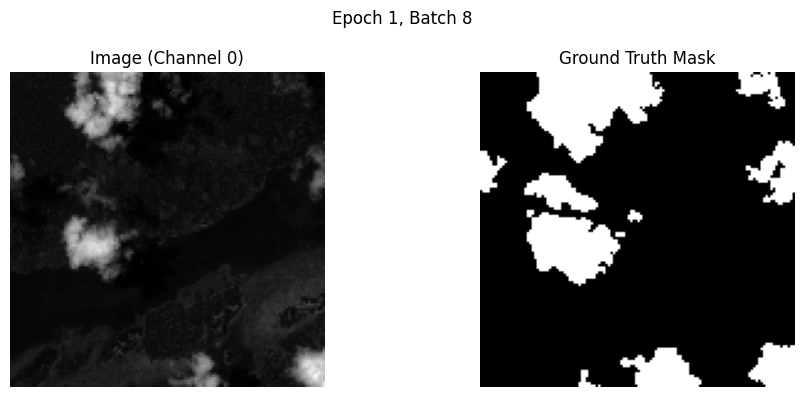

Epoch 1/10:   0%|          | 8/14318 [00:02<1:11:16,  3.35it/s]

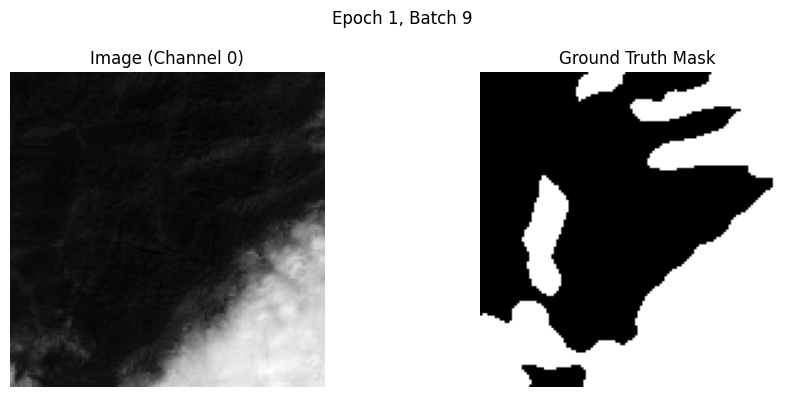

Epoch 1/10:   0%|          | 9/14318 [00:02<1:11:32,  3.33it/s]

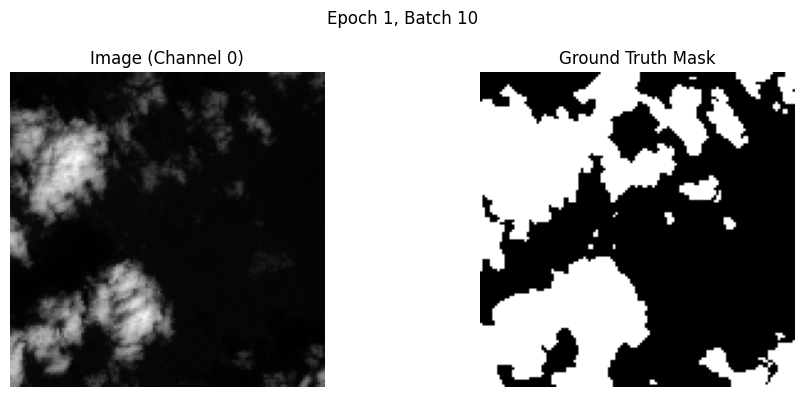

Epoch 1/10: 100%|██████████| 14318/14318 [19:18<00:00, 12.36it/s]
/tmp/ipykernel_182/3670478653.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.long)


Epoch [1/10], Loss: 0.3021
Validation Loss: 0.2598
/kaggle/input/cloud-masking-dataset/content/train/data/924366.tif
uniqueeeeeeee [0]


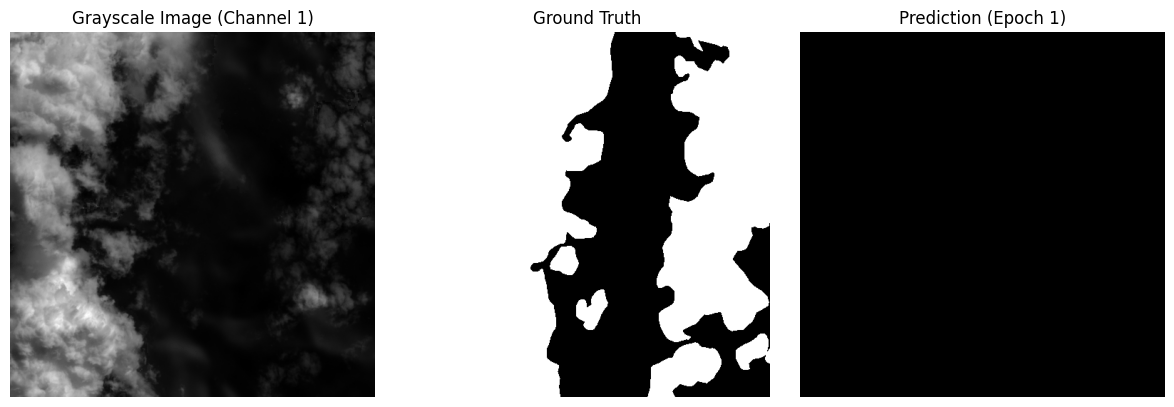

Epoch 2/10: 100%|██████████| 14318/14318 [17:56<00:00, 13.31it/s]


Epoch [2/10], Loss: 0.2630
Validation Loss: 0.2490
/kaggle/input/cloud-masking-dataset/content/train/data/924366.tif
uniqueeeeeeee [0]


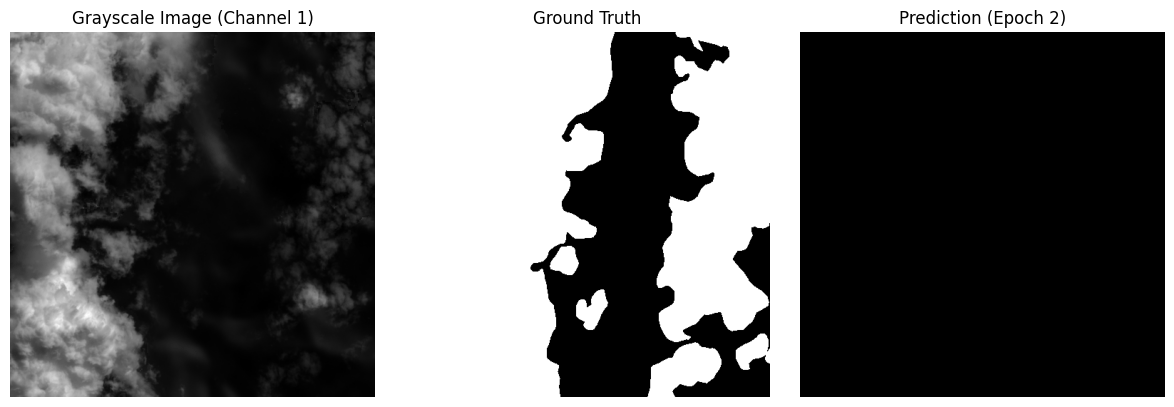

Checkpoint saved at checkpoint_epoch_2.pth


Epoch 3/10:  10%|▉         | 1391/14318 [01:42<15:50, 13.61it/s]


KeyboardInterrupt: 

In [52]:
criterion = nn.BCEWithLogitsLoss()  # Works well for binary masks
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Pick a test image filename from the test split
sample_test_image = test_images[5]  # just pick the first one for consistency
sample_image_path = os.path.join(image_dir, sample_test_image)
sample_mask_path = os.path.join(mask_dir, sample_test_image)

# 6. Training Loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    batch_idx = 0
    for images, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images = images.permute(0,3,1,2).to(device)
        masks = masks.to(device).unsqueeze(1).float()  # [B, 1, H, W]

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        if epoch == 0 and batch_idx < 10:
            img = images[0].detach().cpu().permute(1, 2, 0).numpy()  # [H, W, C]
            mask = masks[0].squeeze().cpu().numpy()  # [H, W]

            # If your image isn't in [0, 255] range, normalize it for display
            if img.max() > 1.0:
                img = img / 255.0

            plt.figure(figsize=(10, 4))

            plt.subplot(1, 2, 1)
            plt.imshow(img[:, :, 0], cmap='gray')  # Only show the first channel
            plt.title("Image (Channel 0)")
            plt.axis('off')

            plt.subplot(1, 2, 2)
            plt.imshow(mask, cmap='gray')
            plt.title("Ground Truth Mask")
            plt.axis('off')

            plt.suptitle(f"Epoch {epoch+1}, Batch {batch_idx+1}")
            plt.tight_layout()
            plt.show()
        batch_idx +=1

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

    # Optional: Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, masks in val_loader:
            images = images.to(device)
            masks = masks.to(device).unsqueeze(1).float()
            outputs = model(images)
            loss = criterion(outputs, masks)
            val_loss += loss.item()
    print(f"Validation Loss: {val_loss/len(val_loader):.4f}")
    show_prediction(model, sample_image_path, sample_mask_path, epoch + 1)

    if (epoch + 1) % 2 == 0:
        checkpoint_path = f"checkpoint_epoch_{epoch+1}.pth"
        torch.save(model.state_dict(), checkpoint_path)
        print(f"Checkpoint saved at {checkpoint_path}")

# 7. Save the trained model
torch.save(model.state_dict(), "unetplusplus.pth")

### Prediction

In [53]:
def dice_coefficient(pred, target):
    pred = pred.flatten() 
    target = target.flatten()  
    intersection = (pred * target).sum()   
    return (2. * intersection) / (pred.sum() + target.sum() + 1e-8)

/tmp/ipykernel_182/468945685.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("checkpoint_epoch_2.pth", map_location=device))
Evaluating 

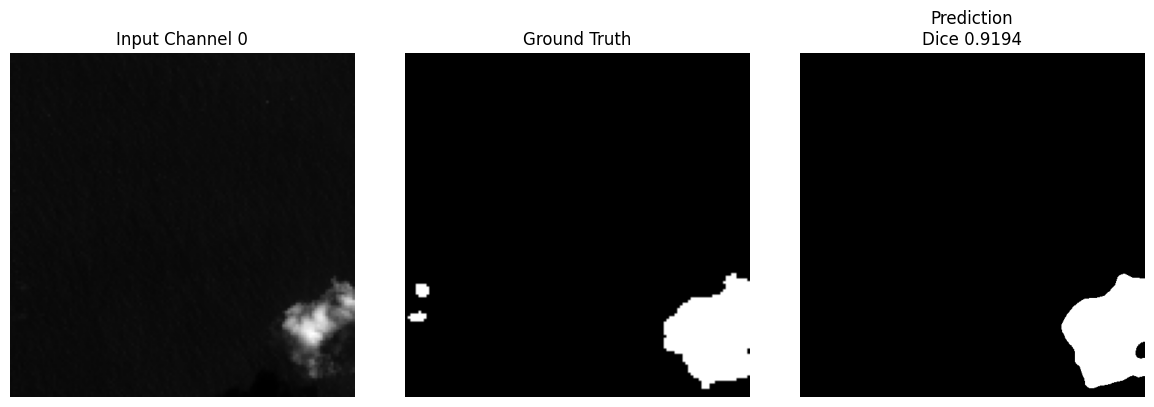

Evaluating on test set:  12%|█▏        | 21/179 [00:02<00:32,  4.82it/s]

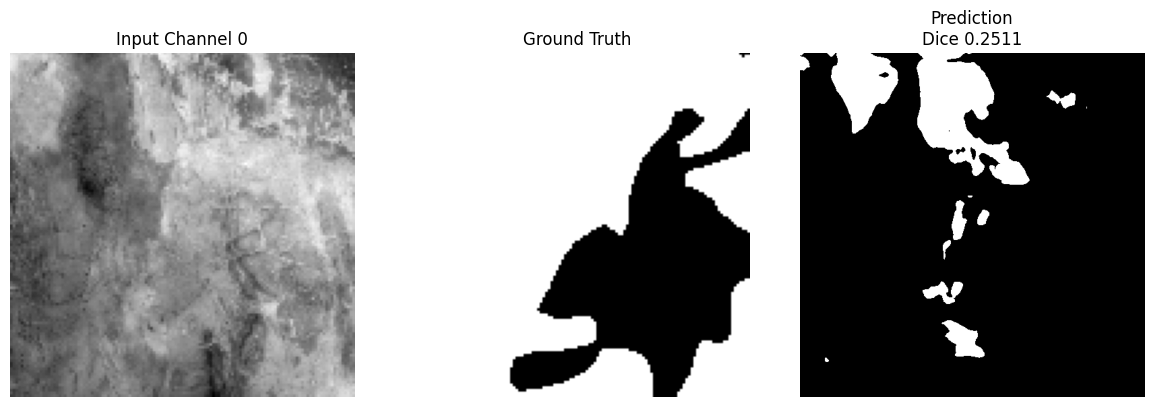

Evaluating on test set:  12%|█▏        | 22/179 [00:03<00:41,  3.79it/s]

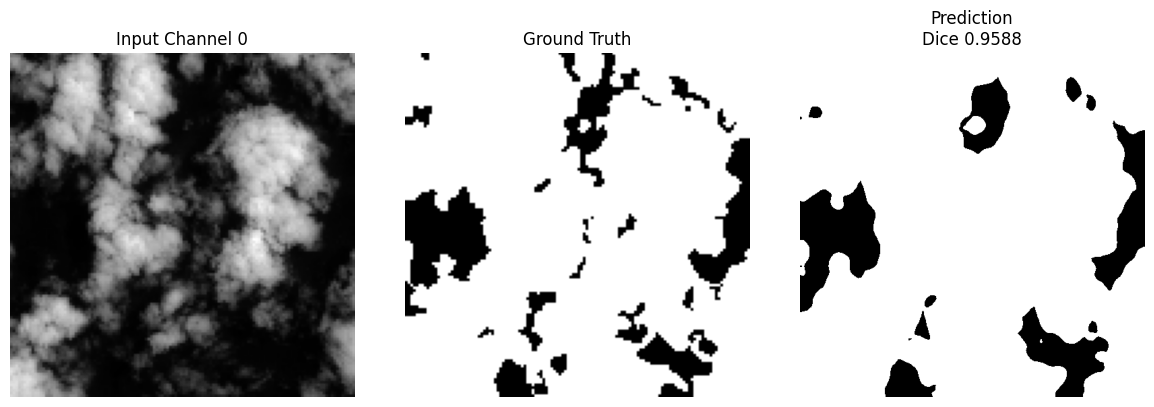

Evaluating on test set:  13%|█▎        | 23/179 [00:03<00:46,  3.36it/s]

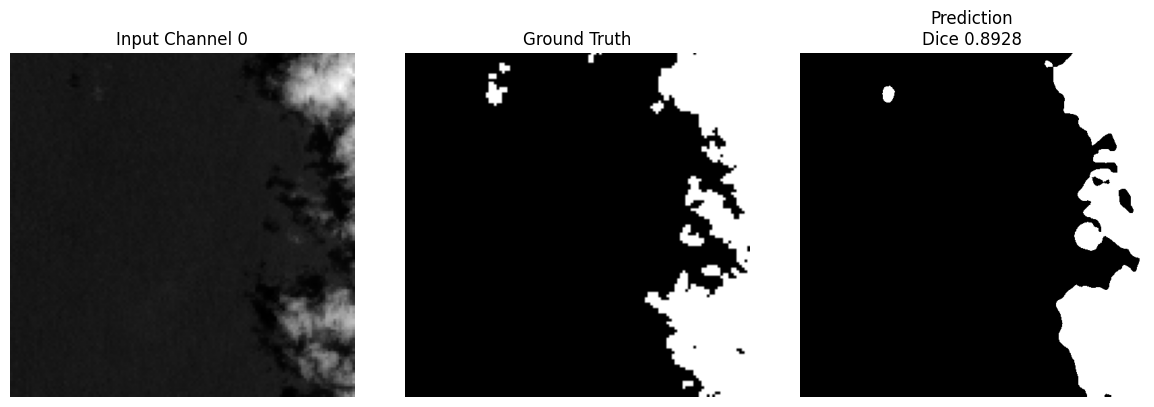

Evaluating on test set:  13%|█▎        | 24/179 [00:03<00:49,  3.13it/s]

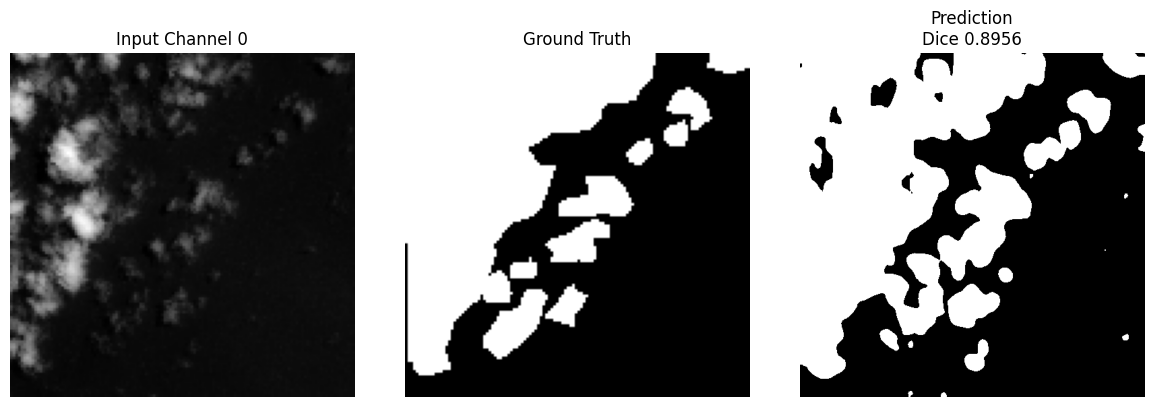

Evaluating on test set:  14%|█▍        | 25/179 [00:04<01:09,  2.21it/s]

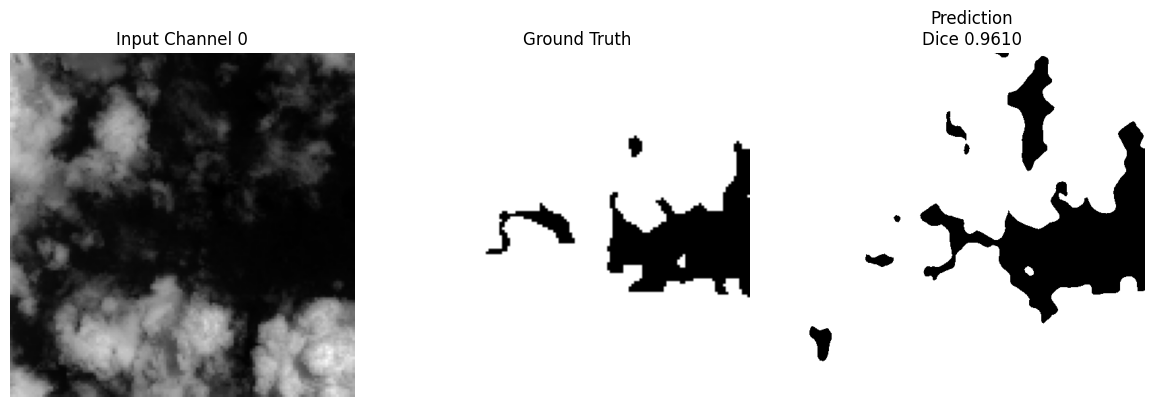

Evaluating on test set:  15%|█▍        | 26/179 [00:05<01:07,  2.28it/s]

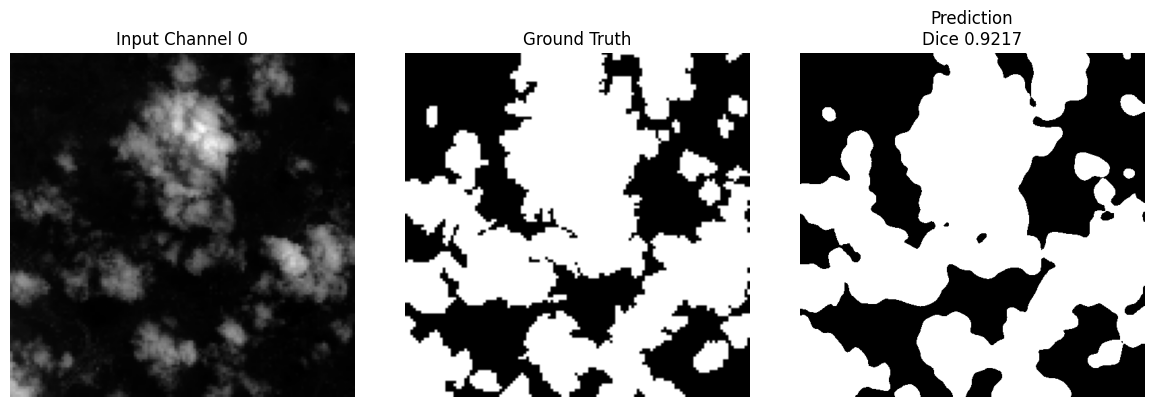

Evaluating on test set:  15%|█▌        | 27/179 [00:05<01:04,  2.34it/s]

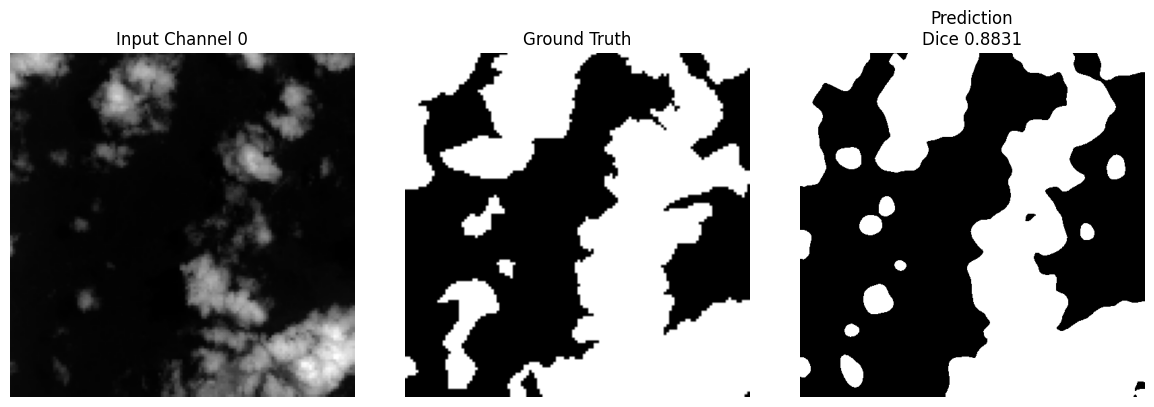

Evaluating on test set:  16%|█▌        | 28/179 [00:05<01:04,  2.36it/s]

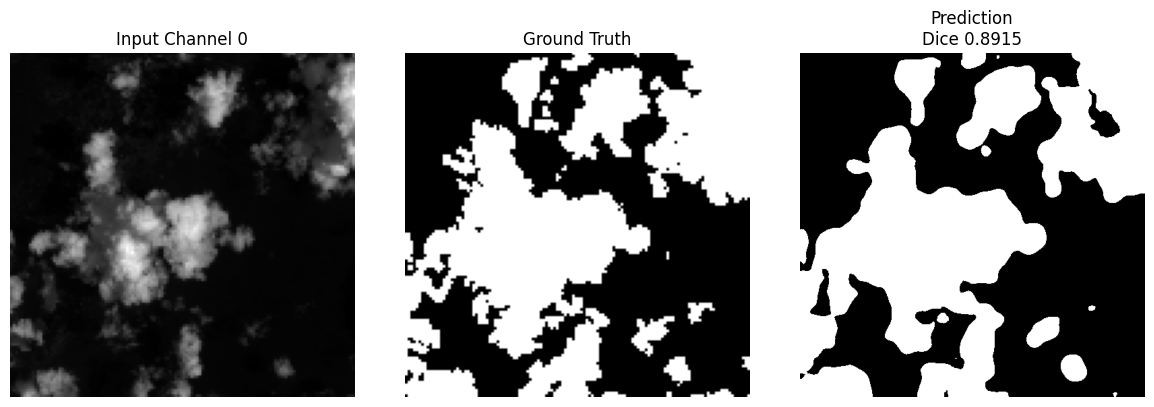

Evaluating on test set:  16%|█▌        | 29/179 [00:06<01:04,  2.34it/s]

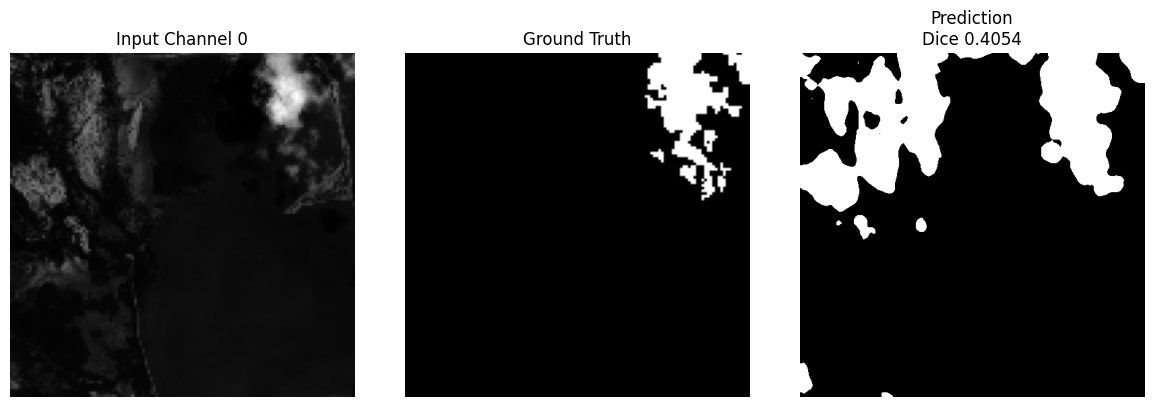

Evaluating on test set: 100%|██████████| 179/179 [00:24<00:00,  7.17it/s]


Average Dice Coefficient on Test Set: 0.8350


In [56]:
# Load the trained model
model = smp.UnetPlusPlus(
    encoder_name='resnet34',
    encoder_weights=None,   # No pre-trained weights
    in_channels=2,          # 2-band input (e.g., channels 0 and 3)
    classes=1               # Binary segmentation
)
model.load_state_dict(torch.load("checkpoint_epoch_2.pth", map_location=device))
# model.load_state_dict(torch.load("/kaggle/input/unetplusplus_original_data/pytorch/default/1/unetplusplus.pth", map_location=device))
model.to(device)

# Evaluate on test set
model.eval()
dice_scores = []
i = 0
with torch.no_grad():
    for image, mask in tqdm(test_loader, desc="Evaluating on test set"):
        # image: [B, 4, H, W]
        image = image.to(device)  # Use only 2 channels: 0 and 3
        mask_np = mask.squeeze().numpy().astype(np.uint8)  # [H, W]
        mask_np = cv2.resize(mask_np[0], (512, 512), interpolation=cv2.INTER_NEAREST)

        output = model(image)  # [B, 1, H, W]
        output = F.interpolate(output, size=(512, 512), mode='bilinear', align_corners=False)
        output = torch.sigmoid(output).squeeze().cpu().numpy()
        pred = (output > 0.5).astype(np.uint8)

        # Handle squeeze based on batch size
        if pred.ndim == 3:
            pred = pred[0]  # [H, W]
        

        dice = dice_coefficient(pred, mask_np)
        dice_scores.append(dice)

        if 20 <= i < 30:
            # Get the original 2-band image (first image in batch)
            full_image = image[0].detach().cpu().numpy()  # [2, H, W]
            mask_np = mask[0].squeeze().cpu().numpy().astype(np.uint8)  # [H, W]
            pred = pred.squeeze()  # [H, W]
        
            # Visualize first input channel only (as grayscale)
            display_image = full_image[0]  # channel 0
        
            if display_image.dtype != np.uint8:
                display_image = (display_image - display_image.min()) / (display_image.max() - display_image.min()) * 255
                display_image = display_image.astype(np.uint8)
        
            plt.figure(figsize=(12, 4))
        
            plt.subplot(1, 3, 1)
            plt.imshow(display_image, cmap='gray')
            plt.title('Input Channel 0')
            plt.axis('off')
        
            plt.subplot(1, 3, 2)
            plt.imshow(mask_np, cmap='gray')
            plt.title('Ground Truth')
            plt.axis('off')
        
            plt.subplot(1, 3, 3)
            plt.imshow(pred, cmap='gray')
            plt.title(f'Prediction\nDice {dice:.4f}')
            plt.axis('off')
        
            plt.tight_layout()
            plt.show()

        i += 1

# Compute average Dice score
average_dice = sum(dice_scores) / len(dice_scores)
print(f"\nAverage Dice Coefficient on Test Set: {average_dice:.4f}")